In [3]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pytorch_lightning as pl
import random
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def paired_random_crop(img_gt, img_lq, gt_patch_size, scale):
    """Crop aligned patches from GT and LQ images.
    Args:
        img_gt (ndarray): HR image (H, W, C)
        img_lq (ndarray): LR image (h, w, C)
        gt_patch_size (int): cropped size for GT image
        scale (int): scale factor between HR and LR
    """
    h_lq, w_lq = img_lq.shape[:2]
    lq_patch_size = gt_patch_size // scale

    # ランダムにLQの左上座標を決定
    top = random.randint(0, h_lq - lq_patch_size)
    left = random.randint(0, w_lq - lq_patch_size)

    # LQを切り出し
    img_lq_patch = img_lq[top:top + lq_patch_size, left:left + lq_patch_size, ...]

    # 対応するGTを切り出し
    top_gt, left_gt = int(top * scale), int(left * scale)
    img_gt_patch = img_gt[top_gt:top_gt + gt_patch_size, left_gt:left_gt + gt_patch_size, ...]

    return img_gt_patch, img_lq_patch


class DIV2KDataset(Dataset):
    def __init__(self, root_dir, split='train', scale=2, gt_size=96):
        self.split = split
        self.scale = scale
        self.gt_size = gt_size
        if split == 'train':
            self.hr_dir = os.path.join(root_dir, 'DIV2K_train_HR')
            self.lr_dir = os.path.join(root_dir, f'DIV2K_train_LR_bicubic/X{scale}')
            self.indices = range(1, 801)
        elif split == 'val':
            self.hr_dir = os.path.join(root_dir, 'DIV2K_valid_HR')
            self.lr_dir = os.path.join(root_dir, f'DIV2K_valid_LR_bicubic/X{scale}')
            self.indices = range(801, 901)
        else:
            raise ValueError(f"Unknown split: {split}")

        self.to_tensor = transforms.ToTensor()

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img_id = f"{self.indices[idx]:04d}"
        lr_path = os.path.join(self.lr_dir, f"{img_id}x{self.scale}.png")
        hr_path = os.path.join(self.hr_dir, f"{img_id}.png")

        # PIL → numpy
        img_lq = np.array(Image.open(lr_path).convert('RGB'))
        img_gt = np.array(Image.open(hr_path).convert('RGB'))

        if self.split == 'train':
            img_gt, img_lq = paired_random_crop(img_gt, img_lq, self.gt_size, self.scale)

            # # 追加のデータ拡張（flip/rotate）
            # if random.random() < 0.5:
            #     img_gt = np.fliplr(img_gt).copy()
            #     img_lq = np.fliplr(img_lq).copy()
            # if random.random() < 0.5:
            #     img_gt = np.flipud(img_gt).copy()
            #     img_lq = np.flipud(img_lq).copy()
            # if random.random() < 0.5:
            #     img_gt = img_gt.transpose(1, 0, 2).copy()
            #     img_lq = img_lq.transpose(1, 0, 2).copy()

        # numpy → tensor
        img_gt = self.to_tensor(img_gt)
        img_lq = self.to_tensor(img_lq)

        return img_lq, img_gt

In [29]:
data_dir = '/ldisk/DeepLearning/Dataset/DIV2K/'

train_dataset = DIV2KDataset(data_dir, split='train', scale=3, gt_size=96)
val_dataset = DIV2KDataset(data_dir, split='val', scale=3, gt_size=96)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

In [33]:
image_lr, image_hr = next(iter(train_loader))
print(f'LR image shape: {image_lr.shape}, HR image shape: {image_hr.shape}')

LR image shape: torch.Size([16, 3, 32, 32]), HR image shape: torch.Size([16, 3, 96, 96])


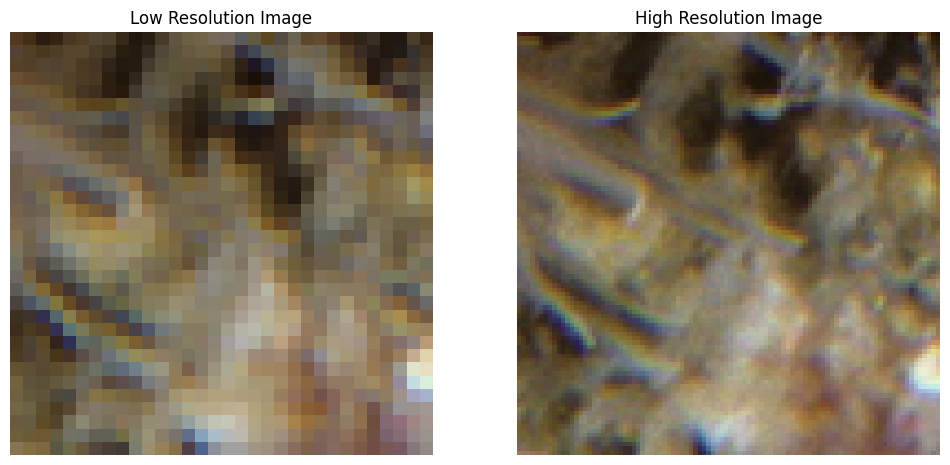

In [34]:
import matplotlib.pyplot as plt

def show_images(lr, hr):
    """Display LR and HR images side by side."""
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].imshow(lr.permute(1, 2, 0).numpy())
    axes[0].set_title('Low Resolution Image')
    axes[0].axis('off')

    axes[1].imshow(hr.permute(1, 2, 0).numpy())
    axes[1].set_title('High Resolution Image')
    axes[1].axis('off')

    plt.show()
show_images(image_lr[0], image_hr[0])

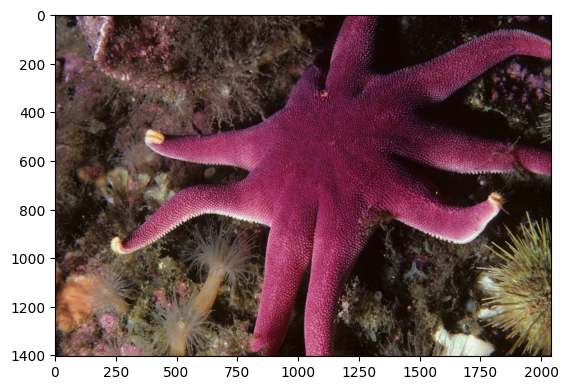

In [21]:
img = np.array(Image.open('/ldisk/DeepLearning/Dataset/DIV2K/DIV2K_train_HR/0001.png').convert('RGB'))

plt.imshow(img)

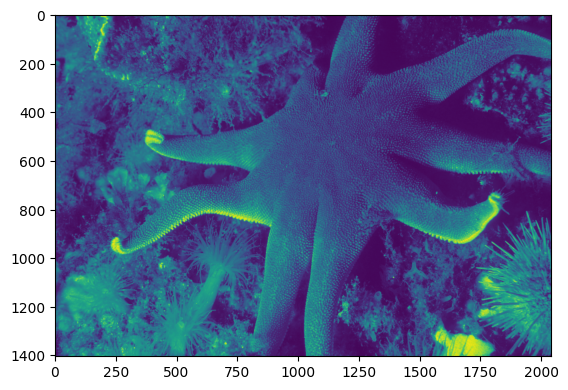

In [14]:
img = np.array(Image.open('/ldisk/DeepLearning/Dataset/DIV2K/DIV2K_train_HR/0001.png').convert('YCbCr'))[..., 0] / 255.0

plt.imshow(img)

In [13]:
img.shape

(1404, 2040)